In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [4]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""



,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
813085,285720529,3.16,12.208234,14.216320,5.237787,NaN,None,NL,None,1975.0,5,0.871253,7.605434,769.0,South Holland
690109,307016317,2.57,19.561703,18.828951,7.053405,NaN,None,NL,None,1970.0,5,0.832688,8.953121,1011.0,South Holland
1210306,273627957,3.00,5.074582,9.894413,3.794322,NaN,None,NL,None,1992.0,5,0.807077,6.592345,478.0,South Holland
876731,270947348,6.09,113.670222,43.119975,15.420618,NaN,None,NL,None,1978.0,5,0.876496,13.205864,201.0,South Holland
1497770,254771777,9.80,65.167027,34.959673,12.361194,NaN,None,NL,None,2008.0,11,0.818562,12.304398,464.0,South Holland


In [ ]:
full_df = bq.Client().query(query).to_dataframe()
full_df.head()

In [ ]:
ml_df = full_df.sample(frac=0.1, random_state=sampling_seed)
ml_df.head()

In [5]:
print(ml_df.shape)

(163867, 15)


In [6]:
print(ml_df.dtypes)

osm_way_id          object
bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object


In [7]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [8]:
print('count unique city:', len(pd.unique(ml_df['city'])))
print('unique city:', pd.unique(ml_df['city']))

print('\ncount unique postcode:', len(pd.unique(ml_df['postcode'])))
print('unique postcode:', pd.unique(ml_df['postcode']))

print('\ncount unique year:', len(pd.unique(ml_df['year'])))
print('unique year:', pd.unique(ml_df['year']))

count unique city: 41
unique city: [NaN, Wassenaar, Delft, 's-Gravendeel, Rijswijk, ..., Moerkapelle, Oud-Alblas, Zoeterwoude, Noordwijkerhout, Alblasserdam]
Length: 41
Categories (40, object): [Wassenaar, Delft, 's-Gravendeel, Rijswijk, ..., Oud-Alblas, Zoeterwoude, Noordwijkerhout, Alblasserdam]

count unique postcode: 89
unique postcode: [NaN, 2241KJ, 2623EW, 2611GW, 3295KG, ..., 2283TB, 2952BX, 2511EK, 3297LJ, 2553TR]
Length: 89
Categories (88, object): [2241KJ, 2623EW, 2611GW, 3295KG, ..., 2952BX, 2511EK, 3297LJ, 2553TR]

count unique year: 386
unique year: [1975. 1970. 1992. 1978. 2008. 1966. 2005. 1995. 1965. 1985. 1991. 1952.
 1942. 2002. 2009. 1988. 1969. 1949. 1994. 1954. 1982. 1874. 1987. 1955.
 1979. 2006. 1993. 1981. 2010. 1960. 1980. 1913. 2017. 1900. 1948. 1990.
 1939. 1997. 2000. 1962. 1976. 1971. 1920. 1957. 2007. 1989. 2004. 1916.
 1938. 1934. 2001. 1961. 1968. 1950. 1928. 1905. 1956. 1998. 1912. 1983.
 1933. 2012. 1974. 1958. 1937. 1895. 1999. 1935. 1977. 2013. 2003.

In [9]:
ml_df.isna().sum()


bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161542
city               163775
country                 0
postcode           163776
year                   18
count_vertices          0
compactness             0
complexity              0
count_neighbor         23
state_name              0
dtype: int64

In [10]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
# drop country as it is irrelevant in this model
ml_df = ml_df.drop(['country', 'state_name'], axis=1)
# drop count_neighbor for now as it is irrelevant in this model
# ml_df = ml_df.drop('count_neighbor', axis=1)

In [11]:
cat_df_10prct = ml_df[cat_cols]
num_df_10prct = ml_df[num_cols]


In [12]:
num_df_10prct.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2325.000000,163849.000000,163867.000000,163867.000000,163867.000000,163844.000000
mean,124.320658,34.346574,12.455788,1.578495,1970.159012,7.326905,0.820270,11.498783,626.513751
std,1144.997166,42.854556,14.877767,1.887877,36.684794,5.113578,0.070376,5.166690,307.412898
min,0.010049,0.401644,0.144239,-3.000000,1212.000000,4.000000,0.252211,1.268545,1.000000
25%,10.971202,13.753018,5.021353,1.000000,1957.000000,5.000000,0.791528,7.543937,429.000000
50%,50.051329,29.746535,10.845022,1.000000,1976.000000,5.000000,0.844085,11.127256,639.000000
75%,71.500435,38.890377,14.321578,2.000000,1993.000000,8.000000,0.872016,13.347903,834.000000
max,127111.022810,2381.260263,758.776422,43.000000,2020.000000,256.000000,0.999919,158.289235,2119.000000


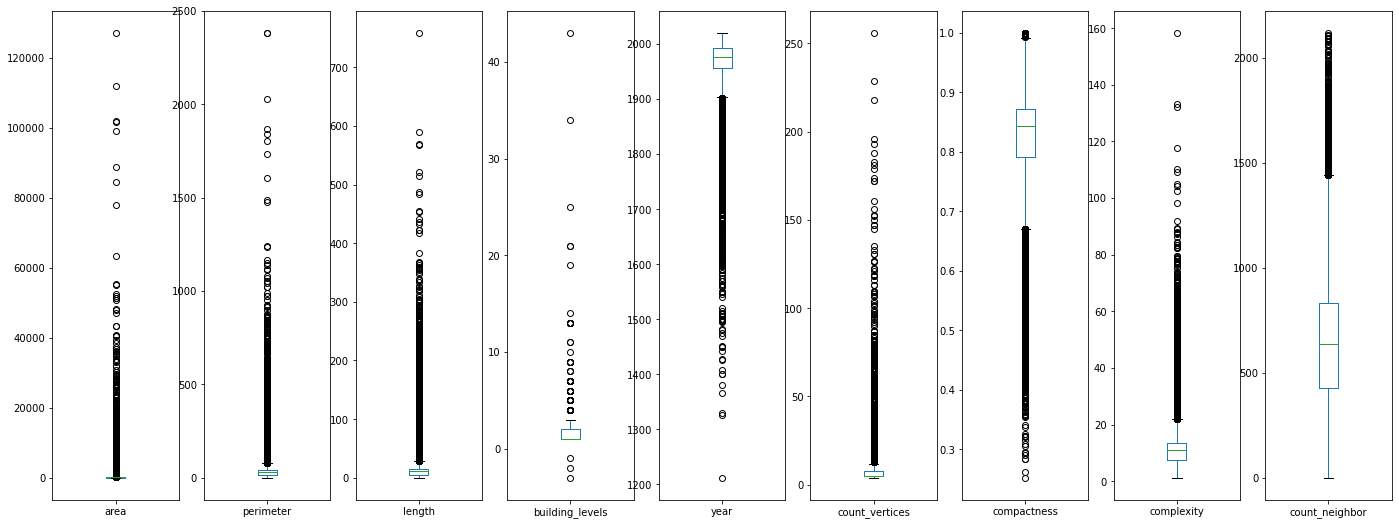

In [13]:

num_df_10prct.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('model_cv_multicollinearity_10prct/run4/exploratory/south_holland_basic_distribution_null.png')

In [14]:
X = ml_df.drop('bldg_height', axis=1)
y = ml_df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=train_test_seed)

In [15]:
X.shape

(163867, 11)

In [16]:
y.shape

(163867,)

In [17]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('normalizer', Normalizer())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('normalizer', Normalizer())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('normalizer', Normalizer())])

In [18]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [20]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [21]:
print(sorted(sklearn.metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [22]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor(random_state=model_seed)))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor(random_state=model_seed)))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor(random_state=model_seed)))
regressors.append(('B', BaggingRegressor(random_state=model_seed)))
regressors.append(('GB', GradientBoostingRegressor(random_state=model_seed)))


In [23]:
mae_reg_scores = {}

In [24]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -3.114472 (std: 0.009889, max: -3.102209, min: -3.124703) took 0.910760 seconds
DT: avg: -3.110557 (std: 0.011471, max: -3.095542, min: -3.126218) took 0.545090 seconds
KNN: avg: -3.288624 (std: 0.165453, max: -3.139447, min: -3.599841) took 0.532650 seconds
RF: avg: -3.115942 (std: 0.012055, max: -3.097854, min: -3.133994) took 0.541705 seconds
AB: avg: -3.130230 (std: 0.026981, max: -3.097018, min: -3.170139) took 0.542898 seconds
B: avg: -3.110007 (std: 0.006723, max: -3.099737, min: -3.117518) took 0.553745 seconds
GB: avg: -3.108492 (std: 0.010345, max: -3.094697, min: -3.126332) took 0.554777 seconds


In [25]:
mae_reg_scores

{'LR': array([-3.12465886, -3.10220895, -3.11735526, -3.12470322, -3.10343373]),
 'DT': array([-3.1099876 , -3.12621835, -3.09554243, -3.12018492, -3.10084972]),
 'KNN': array([-3.13944681, -3.59984088, -3.30841931, -3.17722087, -3.21819131]),
 'RF': array([-3.13399398, -3.11567243, -3.09785403, -3.1100345 , -3.12215538]),
 'AB': array([-3.10333976, -3.09701781, -3.17013914, -3.13740975, -3.14324224]),
 'B': array([-3.11751817, -3.1129371 , -3.11518792, -3.099737  , -3.10465329]),
 'GB': array([-3.10351336, -3.12633232, -3.09469692, -3.10974924, -3.10817041])}

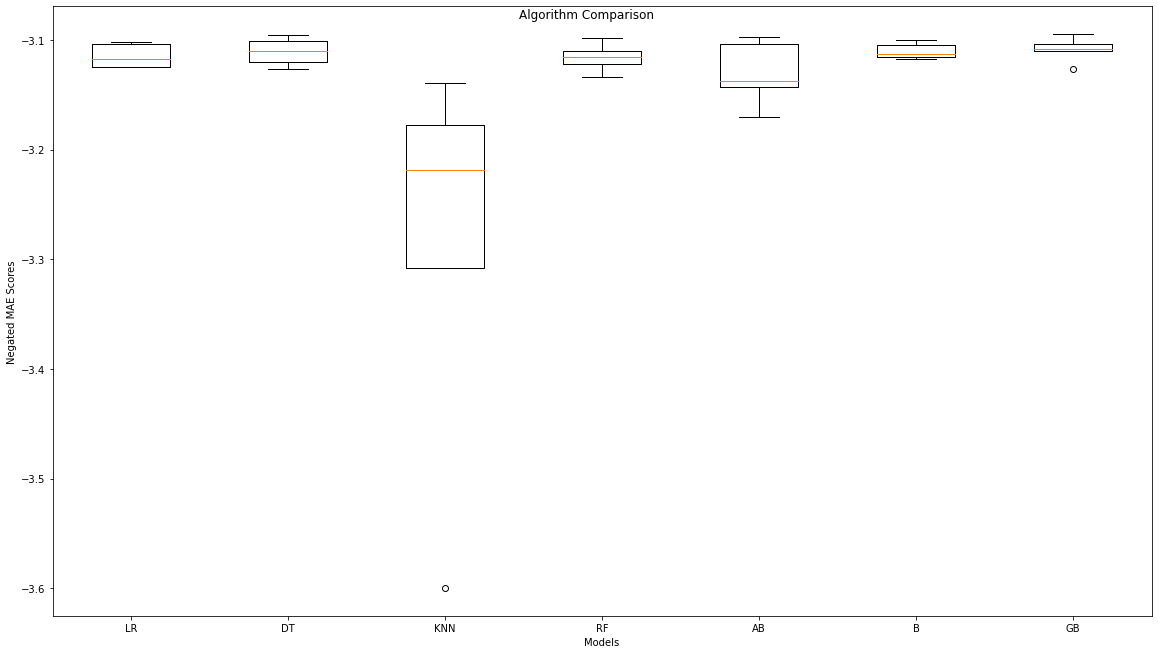

In [26]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_MAE.png', dpi=600)

In [27]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

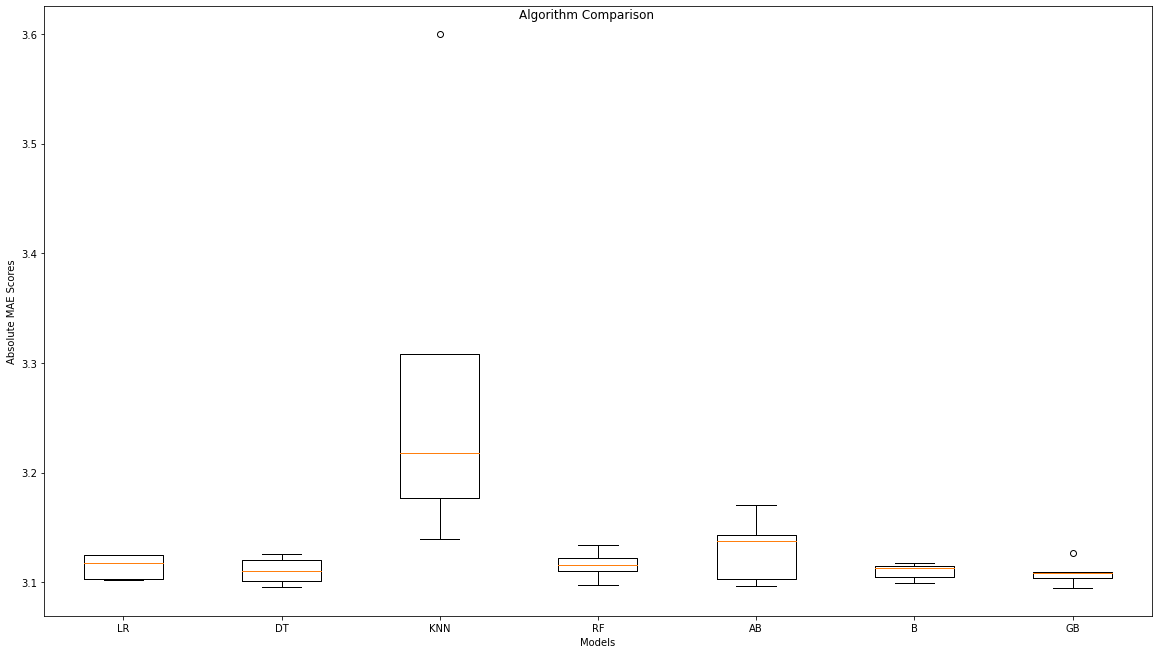

In [28]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_ABS-MAE.png', dpi=600)

In [29]:

if 'KNN' in mae_reg_scores.keys():
    del mae_reg_scores['KNN'] 
mae_reg_scores

{'LR': array([-3.12465886, -3.10220895, -3.11735526, -3.12470322, -3.10343373]),
 'DT': array([-3.1099876 , -3.12621835, -3.09554243, -3.12018492, -3.10084972]),
 'RF': array([-3.13399398, -3.11567243, -3.09785403, -3.1100345 , -3.12215538]),
 'AB': array([-3.10333976, -3.09701781, -3.17013914, -3.13740975, -3.14324224]),
 'B': array([-3.11751817, -3.1129371 , -3.11518792, -3.099737  , -3.10465329]),
 'GB': array([-3.10351336, -3.12633232, -3.09469692, -3.10974924, -3.10817041])}

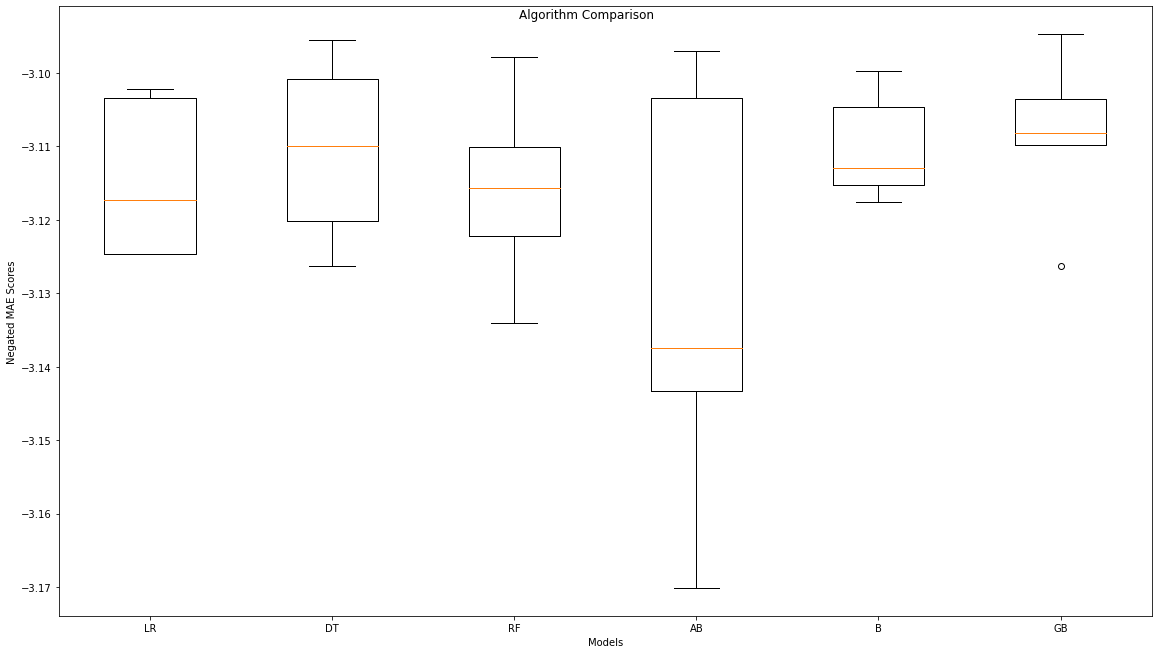

In [30]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_MAE_Except-KNN.png', dpi=600)


In [31]:
if 'KNN' in abs_mae_reg_scores.keys():
    del abs_mae_reg_scores['KNN'] 
abs_mae_reg_scores

{'LR': array([3.12465886, 3.10220895, 3.11735526, 3.12470322, 3.10343373]),
 'DT': array([3.1099876 , 3.12621835, 3.09554243, 3.12018492, 3.10084972]),
 'RF': array([3.13399398, 3.11567243, 3.09785403, 3.1100345 , 3.12215538]),
 'AB': array([3.10333976, 3.09701781, 3.17013914, 3.13740975, 3.14324224]),
 'B': array([3.11751817, 3.1129371 , 3.11518792, 3.099737  , 3.10465329]),
 'GB': array([3.10351336, 3.12633232, 3.09469692, 3.10974924, 3.10817041])}

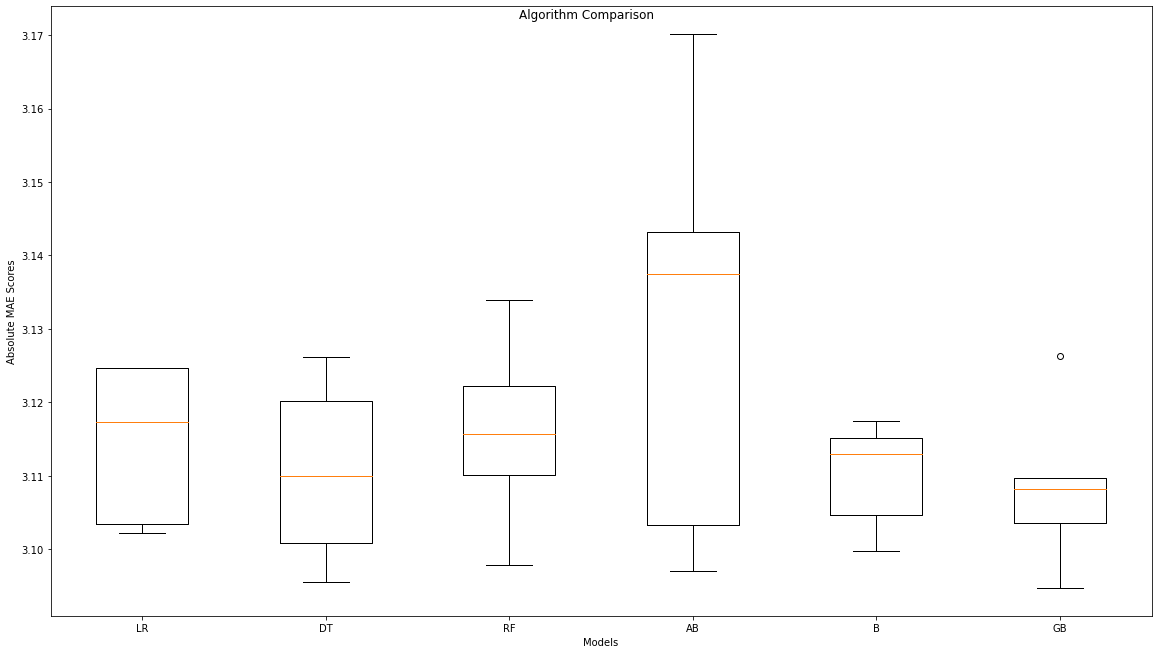

In [32]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_ABS-MAE_Except-KNN.png', dpi=600)

In [33]:
mse_reg_scores = {}

In [34]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -15.016557 (std: 0.459420, max: -14.428325, min: -15.602082) took 0.603066 seconds
DT: avg: -14.805000 (std: 0.697378, max: -13.873707, min: -15.942811) took 0.568676 seconds
KNN: avg: -25.488222 (std: 18.546447, max: -15.123787, min: -62.519799) took 0.564791 seconds
RF: avg: -14.803773 (std: 0.506661, max: -14.074059, min: -15.372302) took 0.547453 seconds
AB: avg: -14.757713 (std: 0.418662, max: -14.252589, min: -15.453652) took 0.545380 seconds
B: avg: -14.824594 (std: 0.468339, max: -14.102727, min: -15.335396) took 0.561517 seconds
GB: avg: -14.806574 (std: 0.594814, max: -14.094455, min: -15.631020) took 0.554922 seconds


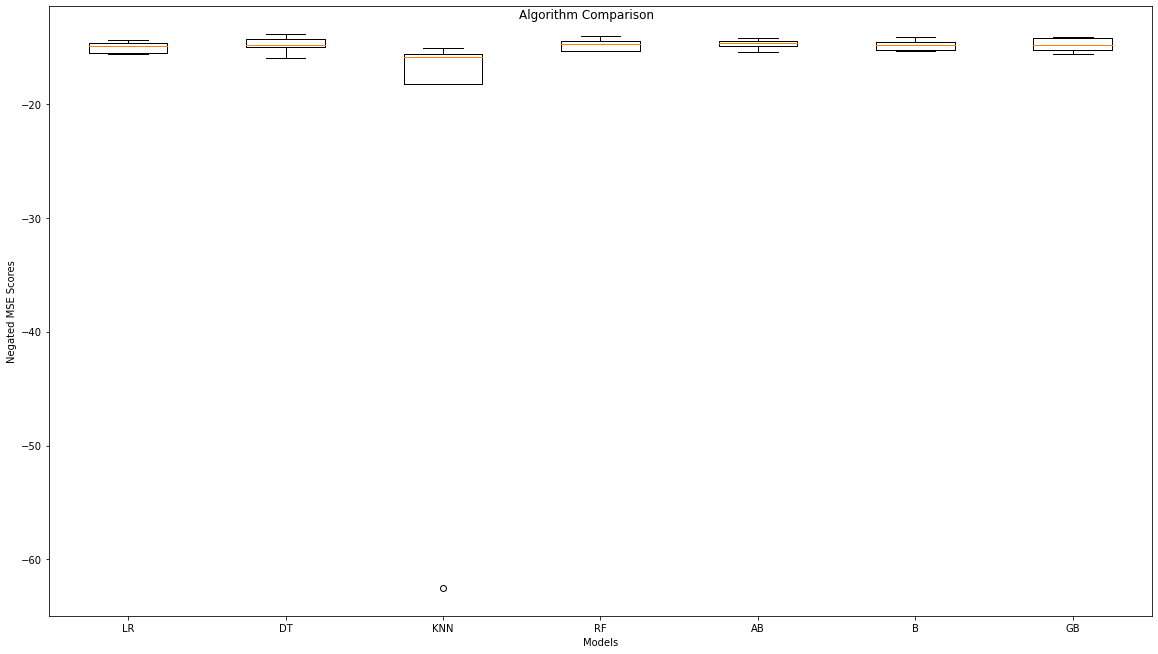

In [35]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_MSE.png', dpi=600)
plt.show()

In [36]:
abs_mse_reg_scores = {}
for k, v in mse_reg_scores.items():
    abs_mse_reg_scores[k] = np.absolute(v)
    
abs_mse_reg_scores

{'LR': array([15.60208171, 15.49406124, 14.89262955, 14.42832508, 14.66568789]),
 'DT': array([15.00943472, 15.94281126, 14.3316362 , 14.86741002, 13.873707  ]),
 'KNN': array([18.23588764, 15.65744522, 15.12378704, 62.51979939, 15.90418825]),
 'RF': array([14.07405933, 14.43962415, 15.34682221, 15.37230189, 14.78605888]),
 'AB': array([14.96002392, 15.45365165, 14.25258927, 14.65785458, 14.46444627]),
 'B': array([14.10272693, 15.29838887, 15.3353964 , 14.52634488, 14.86011248]),
 'GB': array([14.20073569, 15.63102021, 14.83725194, 15.26940739, 14.09445529])}

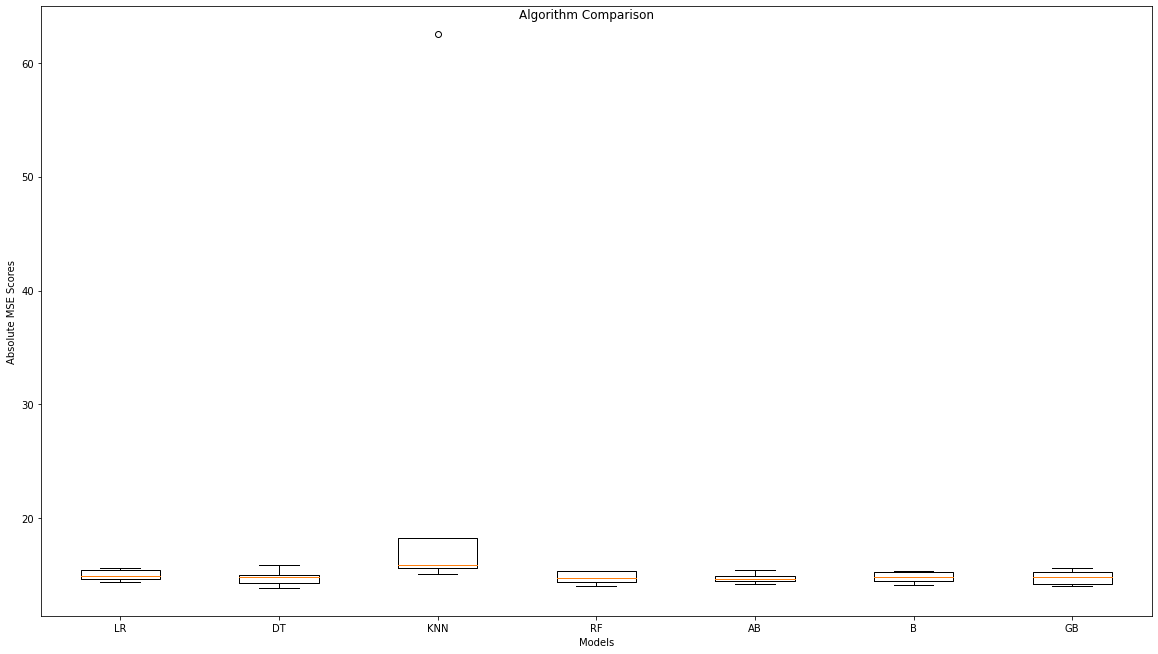

In [37]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_ABS-MSE.png', dpi=600)

In [38]:
if 'KNN' in mse_reg_scores.keys():
    del mse_reg_scores['KNN'] 
mse_reg_scores

{'LR': array([-15.60208171, -15.49406124, -14.89262955, -14.42832508,
        -14.66568789]),
 'DT': array([-15.00943472, -15.94281126, -14.3316362 , -14.86741002,
        -13.873707  ]),
 'RF': array([-14.07405933, -14.43962415, -15.34682221, -15.37230189,
        -14.78605888]),
 'AB': array([-14.96002392, -15.45365165, -14.25258927, -14.65785458,
        -14.46444627]),
 'B': array([-14.10272693, -15.29838887, -15.3353964 , -14.52634488,
        -14.86011248]),
 'GB': array([-14.20073569, -15.63102021, -14.83725194, -15.26940739,
        -14.09445529])}

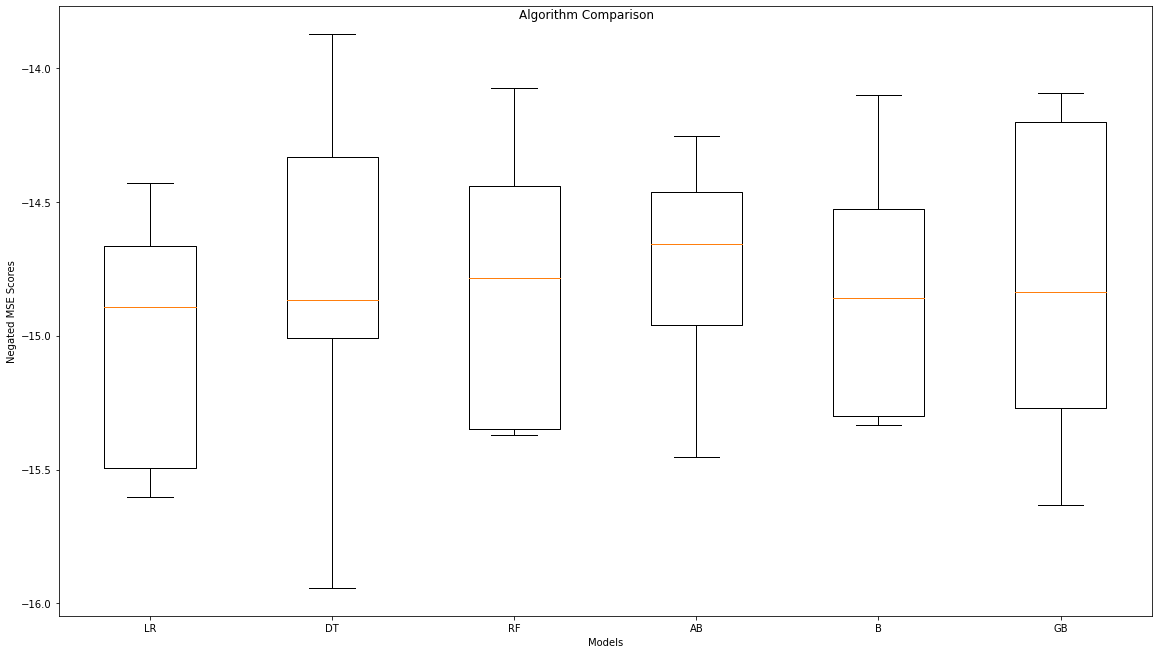

In [39]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_MSE_Except-KNN.png', dpi=600)
plt.show()

In [40]:
if 'KNN' in abs_mse_reg_scores.keys():
    del abs_mse_reg_scores['KNN'] 
abs_mse_reg_scores

{'LR': array([15.60208171, 15.49406124, 14.89262955, 14.42832508, 14.66568789]),
 'DT': array([15.00943472, 15.94281126, 14.3316362 , 14.86741002, 13.873707  ]),
 'RF': array([14.07405933, 14.43962415, 15.34682221, 15.37230189, 14.78605888]),
 'AB': array([14.96002392, 15.45365165, 14.25258927, 14.65785458, 14.46444627]),
 'B': array([14.10272693, 15.29838887, 15.3353964 , 14.52634488, 14.86011248]),
 'GB': array([14.20073569, 15.63102021, 14.83725194, 15.26940739, 14.09445529])}

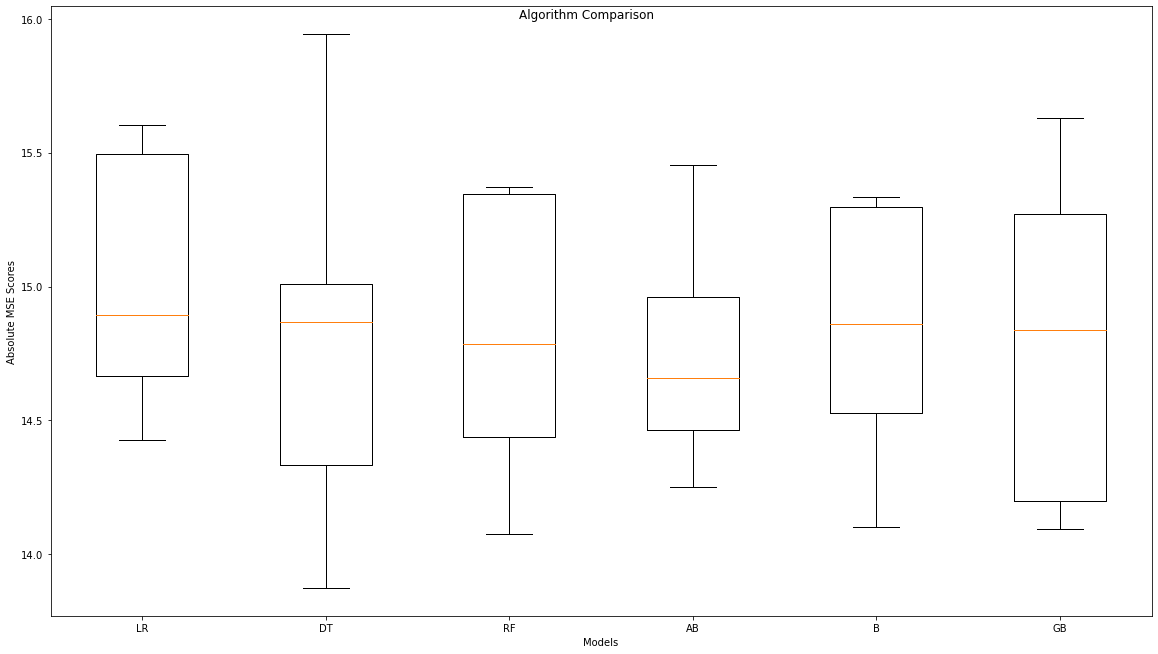

In [41]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_ABS-MSE_Except-KNN.png', dpi=600)
plt.show()

In [42]:
r2_reg_scores = {}

In [43]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: 0.000000 (std: 0.002509, max: 0.004237, min: -0.002685) took 0.554124 seconds
DT: avg: -0.005484 (std: 0.016910, max: 0.003733, min: -0.039270) took 0.547941 seconds
KNN: avg: -0.110838 (std: 0.184700, max: -0.008611, min: -0.479821) took 0.542664 seconds
RF: avg: -0.000245 (std: 0.006012, max: 0.007886, min: -0.010287) took 0.538818 seconds
AB: avg: -0.030731 (std: 0.019466, max: -0.006491, min: -0.054672) took 0.552173 seconds
B: avg: 0.005934 (std: 0.004511, max: 0.012865, min: 0.000445) took 0.548743 seconds
GB: avg: 0.003002 (std: 0.009184, max: 0.015034, min: -0.012569) took 0.582493 seconds


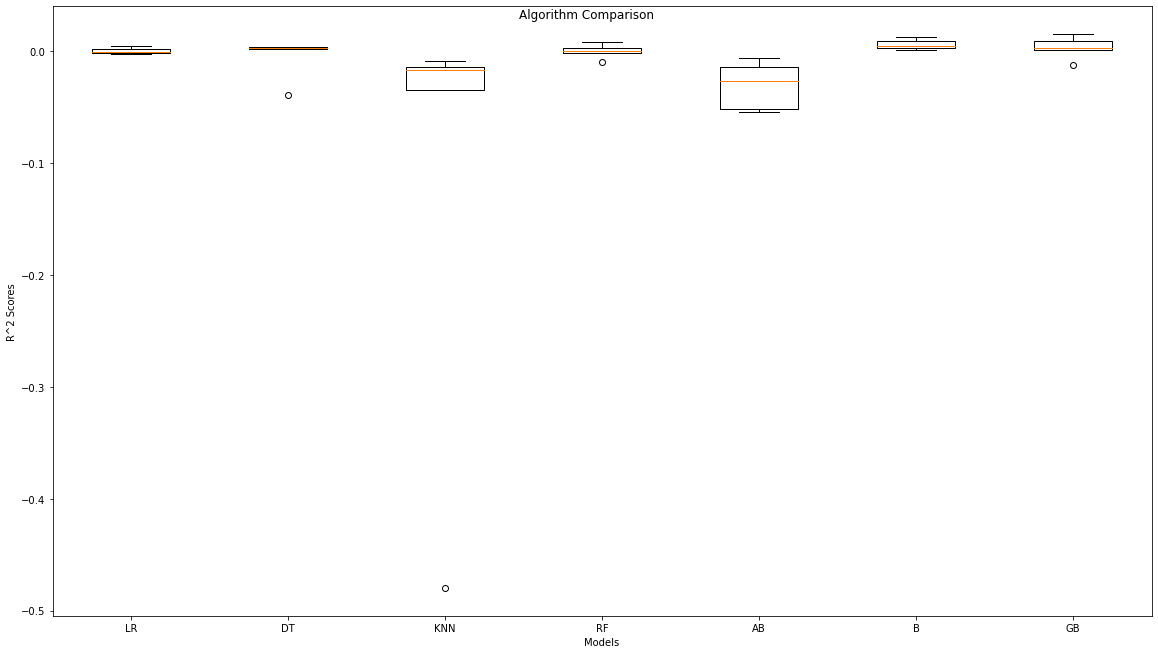

In [44]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_R2.png', dpi=600)
plt.show()

In [45]:
if 'KNN' in r2_reg_scores.keys():
    del r2_reg_scores['KNN']
r2_reg_scores

{'LR': array([-0.00178278, -0.00268451,  0.00136379,  0.00423658, -0.00113064]),
 'DT': array([-0.03927026,  0.00367893,  0.00278159,  0.00165839,  0.00373302]),
 'RF': array([-0.00206586,  0.00788553,  0.0029406 , -0.01028678,  0.0002998 ]),
 'AB': array([-0.05163784, -0.05467199, -0.02692052, -0.01393261, -0.00649091]),
 'B': array([0.00044528, 0.00424602, 0.0028373 , 0.00927474, 0.01286456]),
 'GB': array([ 0.00127474,  0.00266332,  0.01503384,  0.00860533, -0.01256858])}

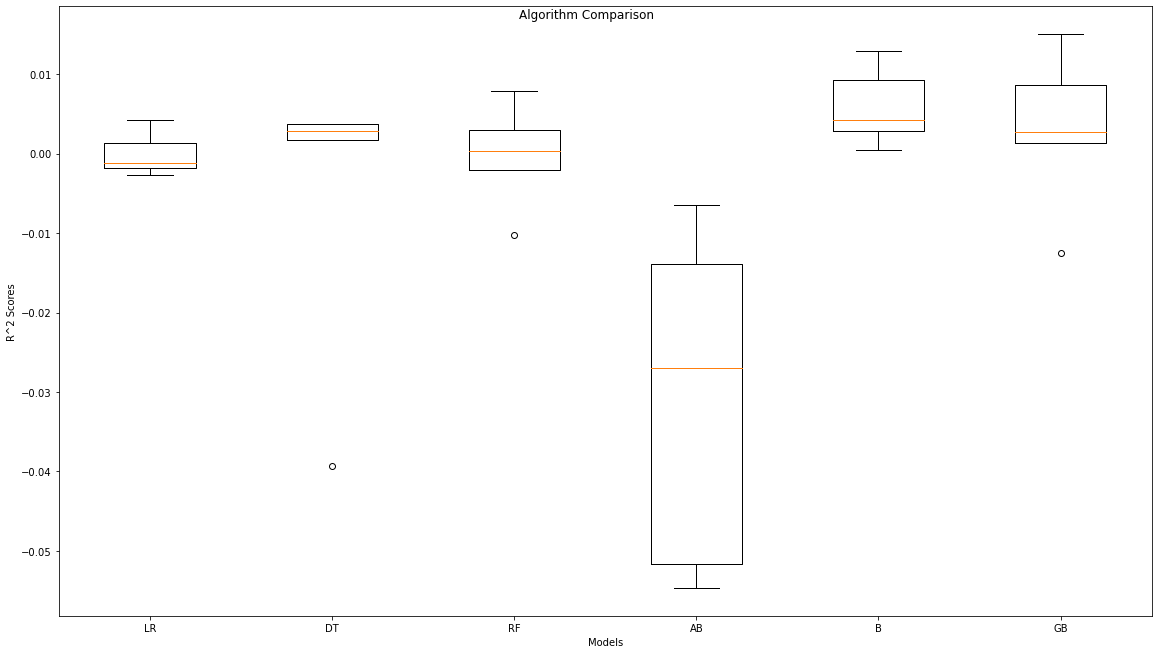

In [46]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/normalizer/South-Holland-10prct_R2_Except-KNN.png', dpi=600)
plt.show()

In [47]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [48]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [49]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [50]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [51]:
print(sorted(sklearn.metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [52]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor(random_state=model_seed)))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor(random_state=model_seed)))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor(random_state=model_seed)))
regressors.append(('B', BaggingRegressor(random_state=model_seed)))
regressors.append(('GB', GradientBoostingRegressor(random_state=model_seed)))


In [53]:
mae_reg_scores = {}

In [54]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -3.028160 (std: 0.010878, max: -3.013889, min: -3.047102) took 1.149300 seconds
DT: avg: -3.403376 (std: 0.019836, max: -3.366016, min: -3.423410) took 0.539289 seconds
KNN: avg: -2.989433 (std: 0.007727, max: -2.975070, min: -2.997933) took 0.551137 seconds
RF: avg: -3.061255 (std: 0.017889, max: -3.043173, min: -3.094537) took 0.563128 seconds
AB: avg: -3.494562 (std: 0.445869, max: -3.107601, min: -4.331855) took 0.916690 seconds
B: avg: -3.107408 (std: 0.015416, max: -3.092373, min: -3.134221) took 0.552992 seconds
GB: avg: -2.858922 (std: 0.004678, max: -2.851108, min: -2.863956) took 0.542285 seconds


In [55]:
mae_reg_scores

{'LR': array([-3.02495162, -3.03041379, -3.04710211, -3.02444577, -3.01388898]),
 'DT': array([-3.40665393, -3.36601562, -3.4048927 , -3.41590776, -3.42341038]),
 'KNN': array([-2.97507029, -2.98902071, -2.99793272, -2.99233091, -2.99280926]),
 'RF': array([-3.05521385, -3.06327074, -3.0945367 , -3.05008106, -3.04317269]),
 'AB': array([-3.45950676, -3.11997804, -3.45387023, -3.1076006 , -4.33185486]),
 'B': array([-3.13422127, -3.09286937, -3.09237326, -3.11253494, -3.1050393 ]),
 'GB': array([-2.8631325 , -2.86395625, -2.85674509, -2.85110781, -2.8596668 ])}

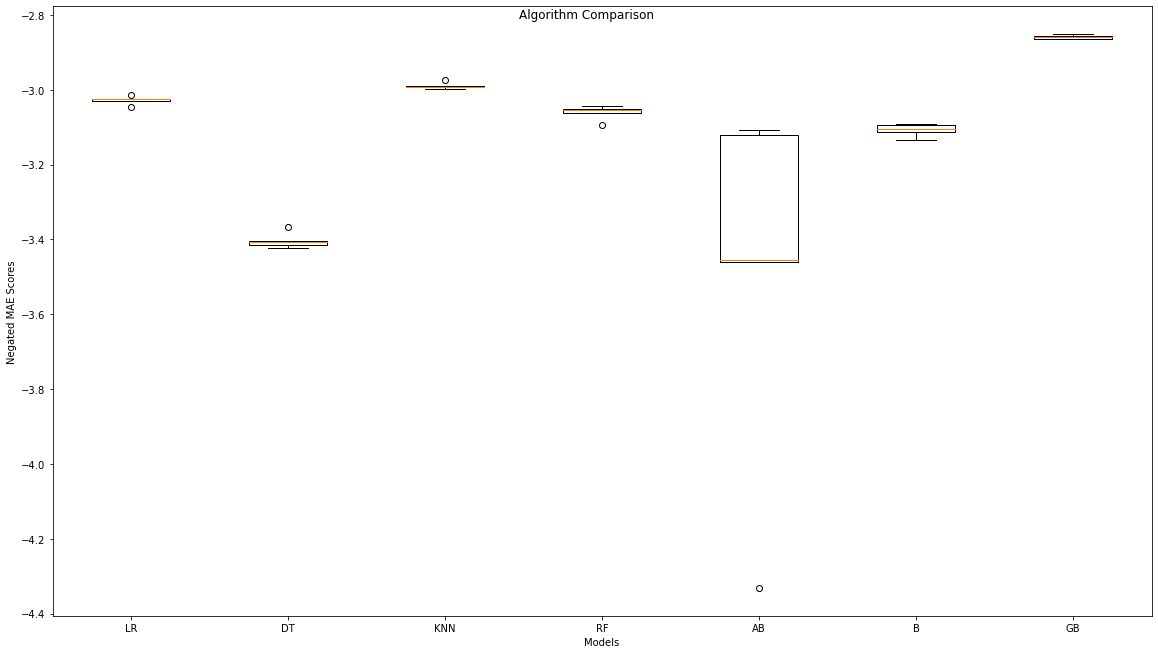

In [56]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_MAE.png', dpi=600)

In [57]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

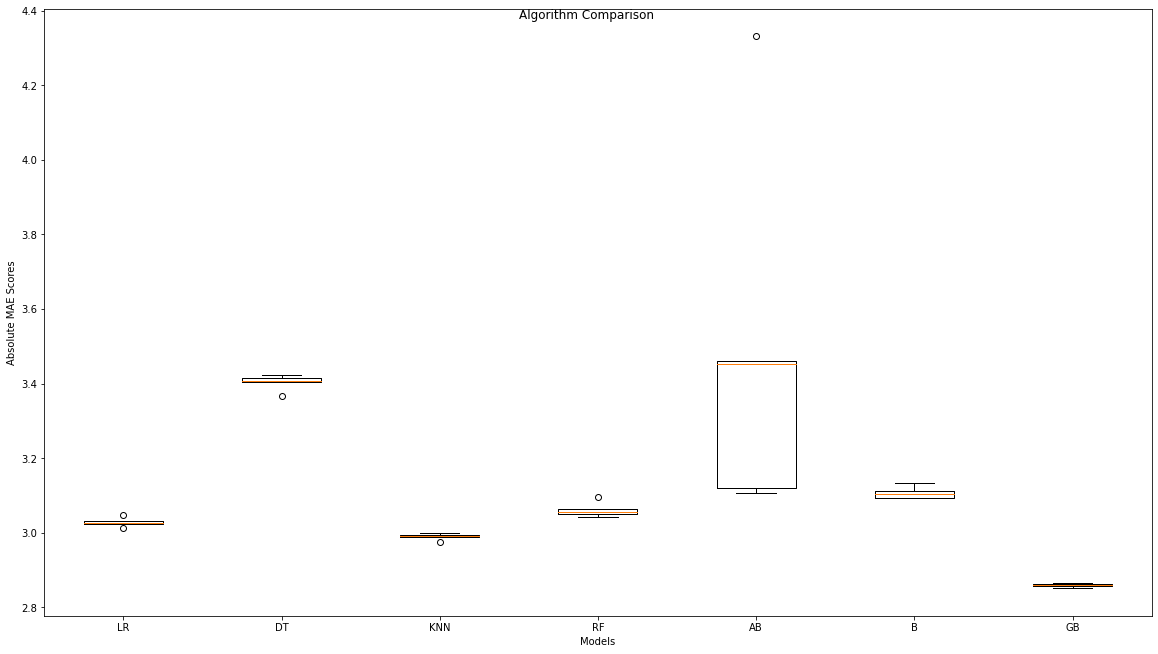

In [58]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_ABS-MAE.png', dpi=600)

In [59]:

if 'AB' in mae_reg_scores.keys():
    del mae_reg_scores['AB'] 
mae_reg_scores

{'LR': array([-3.02495162, -3.03041379, -3.04710211, -3.02444577, -3.01388898]),
 'DT': array([-3.40665393, -3.36601562, -3.4048927 , -3.41590776, -3.42341038]),
 'KNN': array([-2.97507029, -2.98902071, -2.99793272, -2.99233091, -2.99280926]),
 'RF': array([-3.05521385, -3.06327074, -3.0945367 , -3.05008106, -3.04317269]),
 'B': array([-3.13422127, -3.09286937, -3.09237326, -3.11253494, -3.1050393 ]),
 'GB': array([-2.8631325 , -2.86395625, -2.85674509, -2.85110781, -2.8596668 ])}

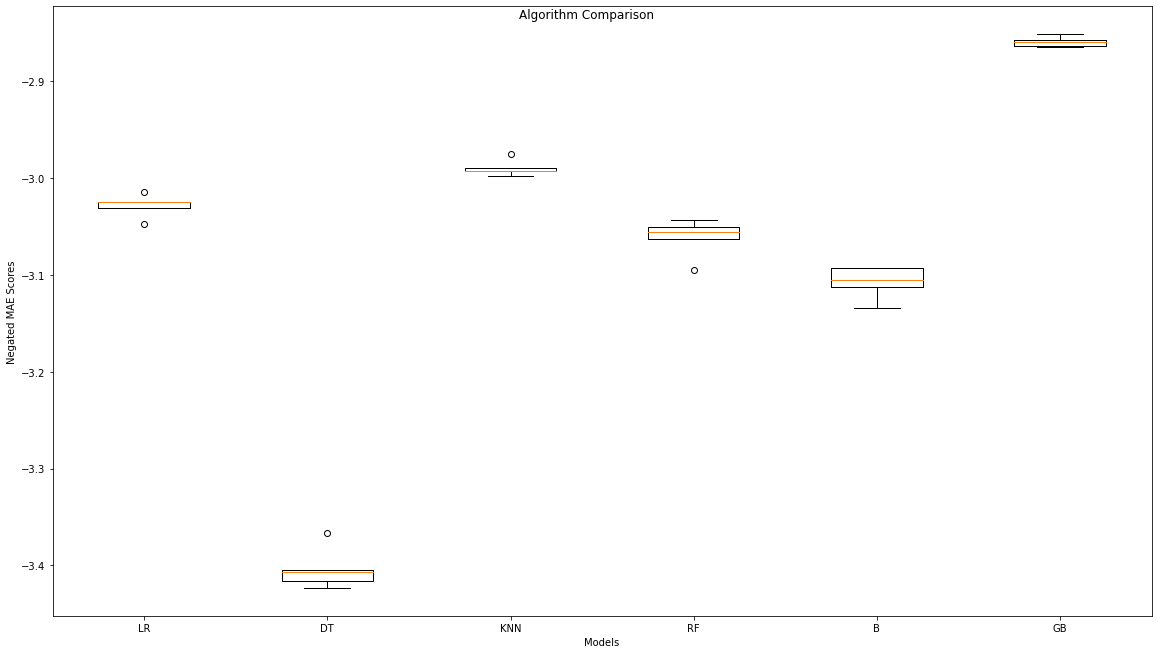

In [60]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_MAE_Except-AB.png', dpi=600)


In [61]:
if 'AB' in abs_mae_reg_scores.keys():
    del abs_mae_reg_scores['AB'] 
abs_mae_reg_scores

{'LR': array([3.02495162, 3.03041379, 3.04710211, 3.02444577, 3.01388898]),
 'DT': array([3.40665393, 3.36601562, 3.4048927 , 3.41590776, 3.42341038]),
 'KNN': array([2.97507029, 2.98902071, 2.99793272, 2.99233091, 2.99280926]),
 'RF': array([3.05521385, 3.06327074, 3.0945367 , 3.05008106, 3.04317269]),
 'B': array([3.13422127, 3.09286937, 3.09237326, 3.11253494, 3.1050393 ]),
 'GB': array([2.8631325 , 2.86395625, 2.85674509, 2.85110781, 2.8596668 ])}

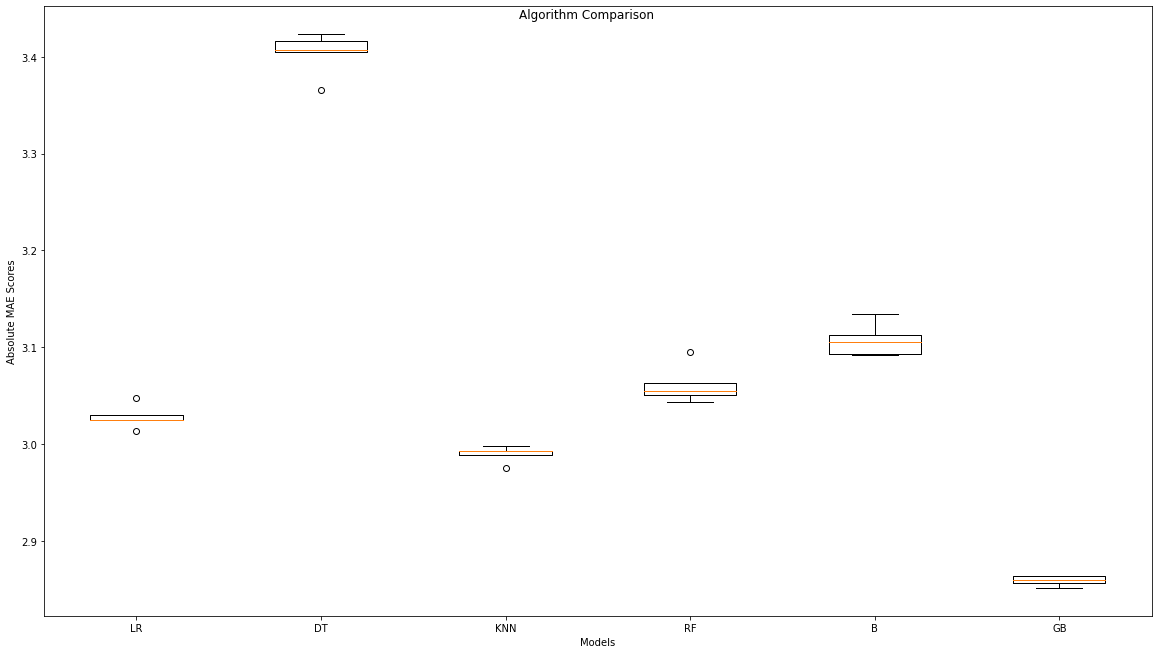

In [62]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_ABS-MAE_Except-AB.png', dpi=600)

In [63]:
mse_reg_scores = {}

In [64]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -13.699878 (std: 0.677253, max: -13.078457, min: -14.992416) took 0.539795 seconds
DT: avg: -22.611187 (std: 0.691037, max: -21.772928, min: -23.706004) took 0.577160 seconds
KNN: avg: -14.424477 (std: 0.185700, max: -14.264964, min: -14.700082) took 0.574724 seconds
RF: avg: -16.930100 (std: 0.723148, max: -15.645862, min: -17.570211) took 0.582057 seconds
AB: avg: -25.346805 (std: 5.256618, max: -16.332556, min: -32.652694) took 0.956008 seconds
B: avg: -17.332522 (std: 0.490044, max: -16.737965, min: -18.021089) took 0.528311 seconds
GB: avg: -12.688880 (std: 0.402115, max: -12.212142, min: -13.303916) took 0.550028 seconds


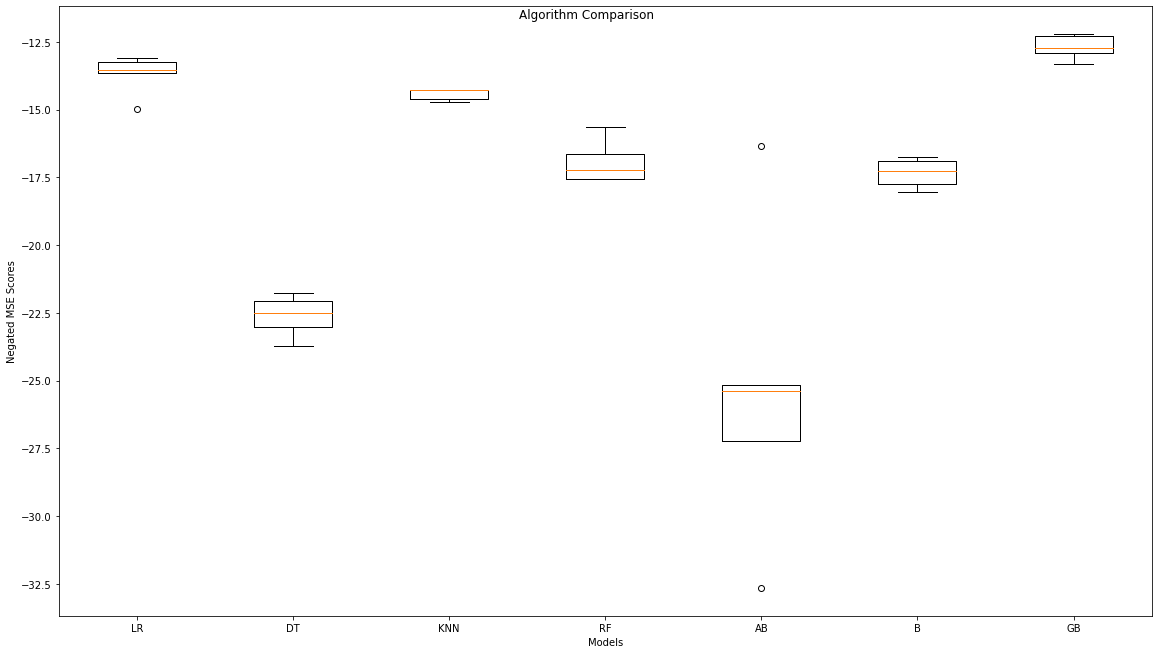

In [65]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_MSE.png', dpi=600)
plt.show()

In [66]:
abs_mse_reg_scores = {}
for k, v in mse_reg_scores.items():
    abs_mse_reg_scores[k] = np.absolute(v)
    
abs_mse_reg_scores

{'LR': array([13.5538755 , 14.99241593, 13.24065974, 13.07845731, 13.63398259]),
 'DT': array([22.50588613, 22.05398192, 21.77292795, 23.01713586, 23.70600393]),
 'KNN': array([14.59637685, 14.70008236, 14.26496421, 14.28074728, 14.28021506]),
 'RF': array([17.23659324, 16.64904138, 17.54878997, 17.57021141, 15.64586248]),
 'AB': array([25.14174437, 27.21313046, 32.65269434, 16.33255588, 25.39389789]),
 'B': array([17.7413132 , 18.0210891 , 16.73796529, 17.28058895, 16.88165156]),
 'GB': array([12.72636535, 12.29596572, 13.30391634, 12.90601035, 12.21214231])}

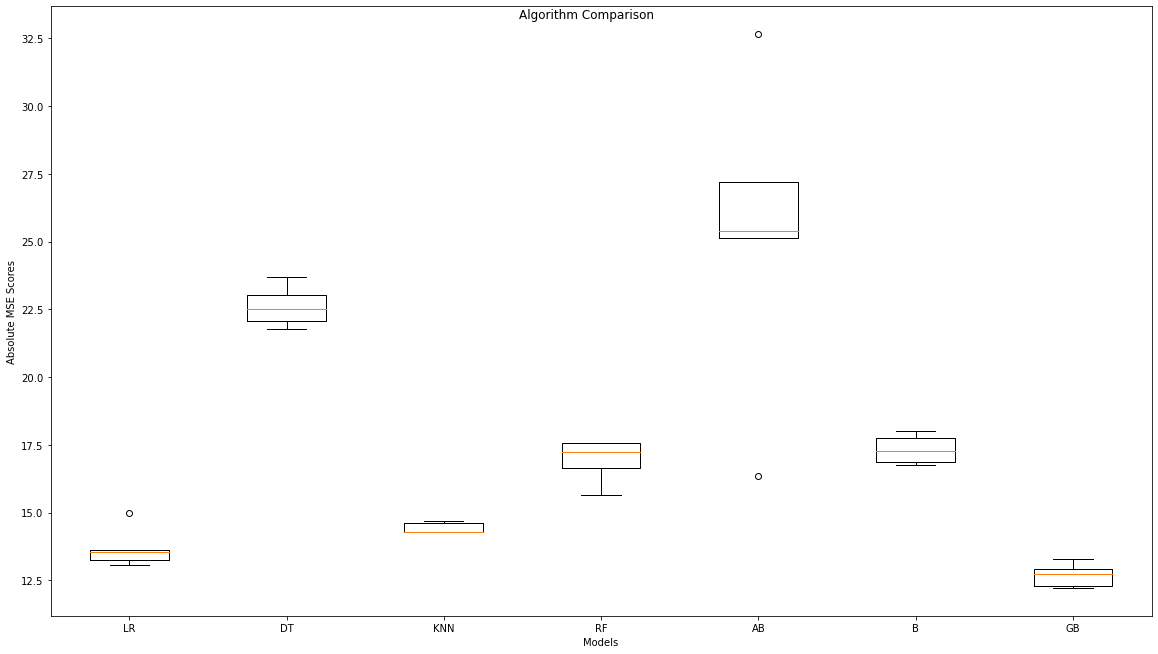

In [67]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_ABS-MSE.png', dpi=600)

In [68]:
if 'AB' in mse_reg_scores.keys():
    del mse_reg_scores['AB'] 
mse_reg_scores

{'LR': array([-13.5538755 , -14.99241593, -13.24065974, -13.07845731,
        -13.63398259]),
 'DT': array([-22.50588613, -22.05398192, -21.77292795, -23.01713586,
        -23.70600393]),
 'KNN': array([-14.59637685, -14.70008236, -14.26496421, -14.28074728,
        -14.28021506]),
 'RF': array([-17.23659324, -16.64904138, -17.54878997, -17.57021141,
        -15.64586248]),
 'B': array([-17.7413132 , -18.0210891 , -16.73796529, -17.28058895,
        -16.88165156]),
 'GB': array([-12.72636535, -12.29596572, -13.30391634, -12.90601035,
        -12.21214231])}

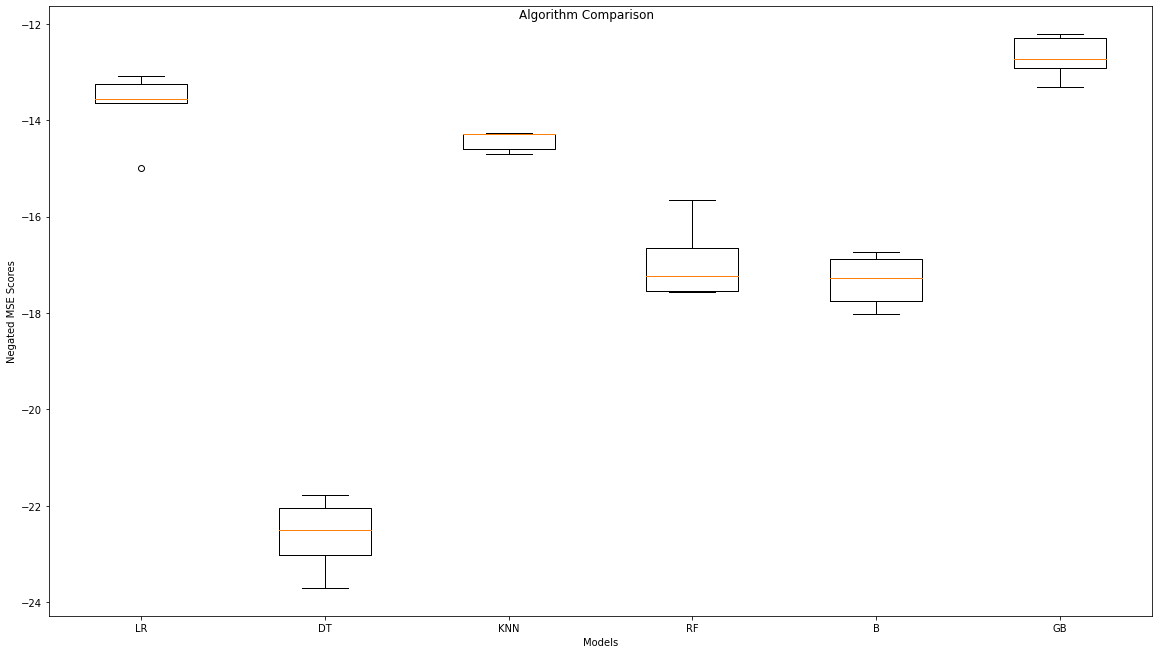

In [69]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_MSE_Except-AB.png', dpi=600)
plt.show()

In [70]:
if 'AB' in abs_mse_reg_scores.keys():
    del abs_mse_reg_scores['AB'] 
abs_mse_reg_scores

{'LR': array([13.5538755 , 14.99241593, 13.24065974, 13.07845731, 13.63398259]),
 'DT': array([22.50588613, 22.05398192, 21.77292795, 23.01713586, 23.70600393]),
 'KNN': array([14.59637685, 14.70008236, 14.26496421, 14.28074728, 14.28021506]),
 'RF': array([17.23659324, 16.64904138, 17.54878997, 17.57021141, 15.64586248]),
 'B': array([17.7413132 , 18.0210891 , 16.73796529, 17.28058895, 16.88165156]),
 'GB': array([12.72636535, 12.29596572, 13.30391634, 12.90601035, 12.21214231])}

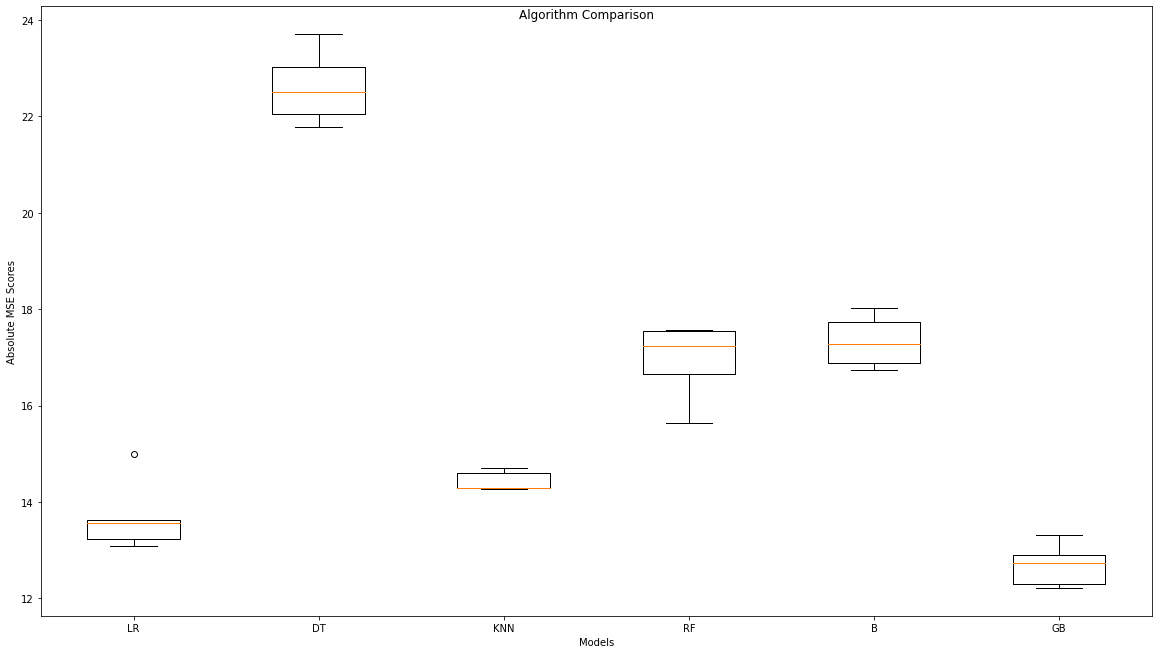

In [71]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_ABS-MSE_Except-AB.png', dpi=600)
plt.show()

In [72]:
r2_reg_scores = {}

In [73]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: 0.067836 (std: 0.017135, max: 0.089813, min: 0.045002) took 0.544738 seconds
DT: avg: -0.542120 (std: 0.042867, max: -0.464334, min: -0.594540) took 0.556325 seconds
KNN: avg: -0.004216 (std: 0.019199, max: 0.012136, min: -0.032910) took 0.582235 seconds
RF: avg: -0.083752 (std: 0.019979, max: -0.054332, min: -0.113451) took 0.590366 seconds
AB: avg: -0.277439 (std: 0.216528, max: -0.094406, min: -0.694012) took 0.914937 seconds
B: avg: -0.163937 (std: 0.054323, max: -0.092862, min: -0.246557) took 0.554470 seconds
GB: avg: 0.141337 (std: 0.014414, max: 0.157891, min: 0.123936) took 0.533065 seconds


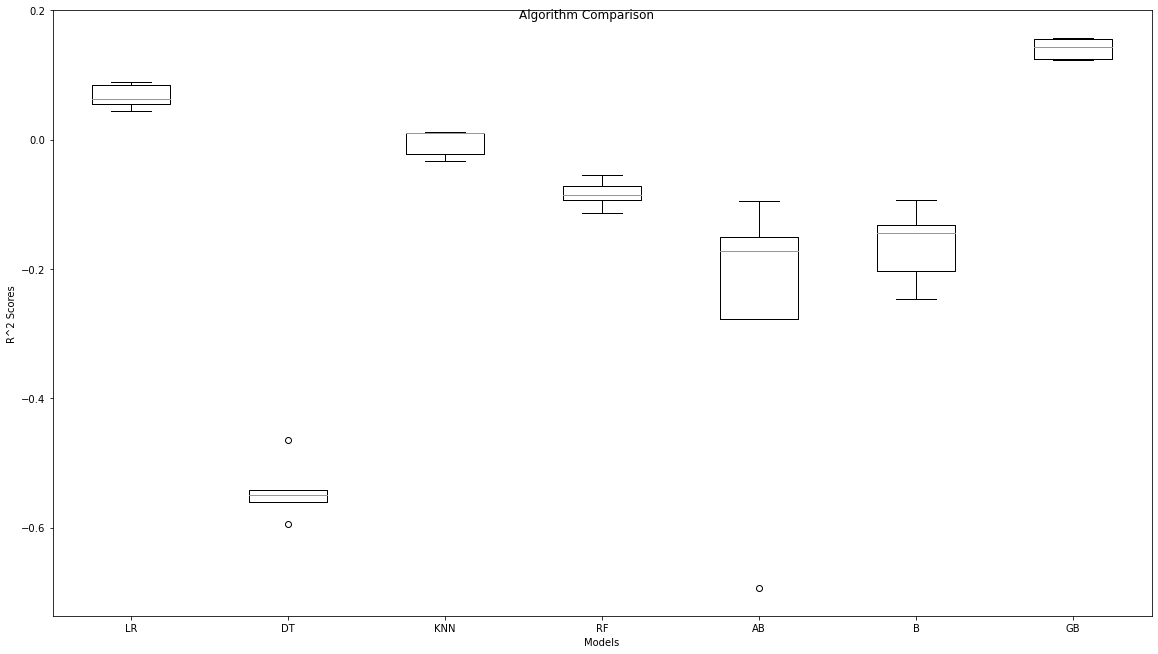

In [74]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/South-Holland-10prct_R2.png', dpi=600)
plt.show()

In [75]:
if 'AB' in r2_reg_scores.keys():
    del r2_reg_scores['AB']
r2_reg_scores

{'LR': array([0.06323716, 0.08981321, 0.0450024 , 0.08518772, 0.05594134]),
 'DT': array([-0.55999937, -0.59454024, -0.46433402, -0.55042365, -0.54130391]),
 'KNN': array([-0.02172341,  0.01213633, -0.03291028,  0.01111035,  0.01030488]),
 'RF': array([-0.08624476, -0.11345148, -0.0543322 , -0.0714508 , -0.09327926]),
 'B': array([-0.14464494, -0.24655713, -0.13263086, -0.20299093, -0.09286244]),
 'GB': array([0.12558711, 0.14346565, 0.12393554, 0.15580793, 0.15789126])}

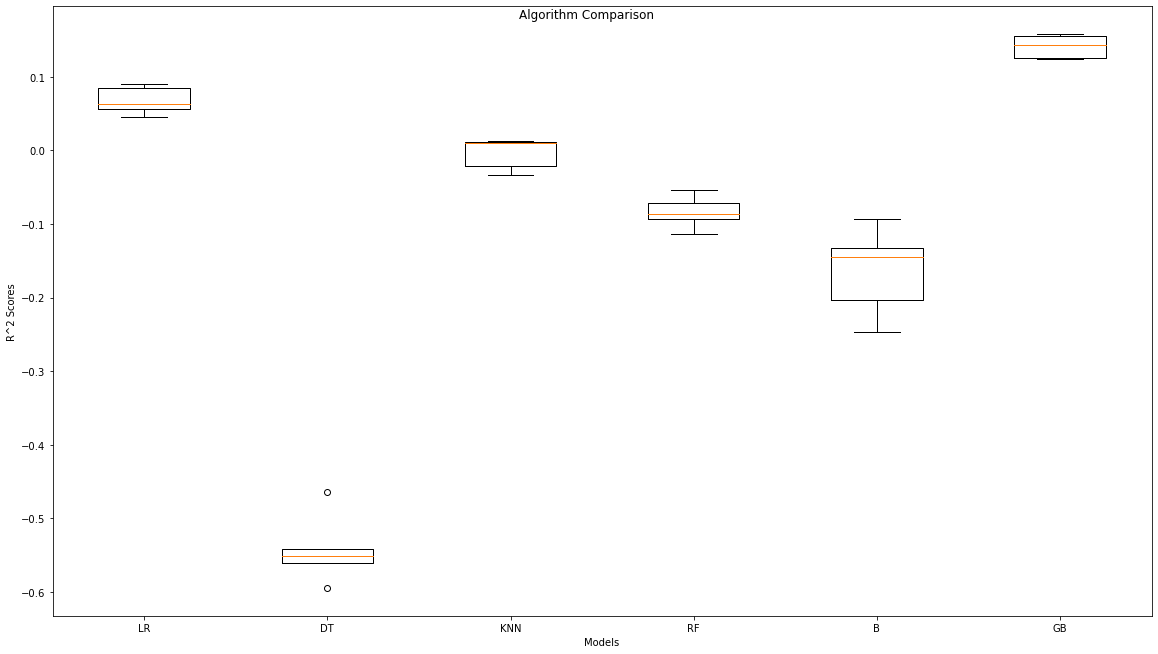

In [76]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_multicollinearity_10prct/run4/scaler/olland-10prct_R2_Except-AB.png', dpi=600)
plt.show()